In [11]:
# load credentials from environment variables
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [12]:
import io
import tarfile
import requests
import rasterio
from datetime import timezone, date, datetime
from  dateutil.relativedelta import relativedelta as rdelta
from rasterio.plot import show
from matplotlib import pyplot
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Your client credentials
client_id = %env SH_CLIENT_ID
client_secret = %env SH_CLIENT_SECRET

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)

resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

In [30]:

day_of_new_interval = 16
startdate = date(2018,7,1)
starttime = datetime(*startdate.timetuple()[:6], tzinfo=timezone.utc)
enddate = date(2018,9,15)
endtime = datetime(*enddate.timetuple()[:6], tzinfo=timezone.utc)

def count_intervals(startdate,enddate):
    if startdate.year == enddate.year and startdate.month == enddate.month:
        intervals = 1 if (startdate.day < day_of_new_interval and enddate.day < day_of_new_interval) or \
                          (startdate.day >= day_of_new_interval and enddate.day >= day_of_new_interval) else 2
        
    else:
        intervals_first = 2 if startdate.day < day_of_new_interval else 1
        intervals_inbetween = abs(rdelta(startdate+rdelta(months=+1, day=1),enddate+rdelta(day=1))).months*2
        intervals_last = 2 if enddate.day >= day_of_new_interval else 1
        intervals = intervals_first + intervals_inbetween + intervals_last
        
    return intervals

endtime

datetime.datetime(2018, 9, 15, 0, 0, tzinfo=datetime.timezone.utc)

In [23]:
input_bands = ["B04","B08"]
masks = ["SCL", "dataMask"] # SCL ... Scene Classification Layer
indices = ['NDVI']
output_bands = input_bands + indices

output_array =  ','.join([f"{{id: '{ob}', bands: {count_intervals(startdate,enddate)}, \
                          sampleType: SampleType.UINT16}}" for ob in output_bands])

int_bands = '{' + ','.join([f'{ib}: []' for ib in input_bands]) + '}'
results_object = '{' + ','.join([f'{ob}: []' for ob in output_bands]) + '}'
debug_results = '{' + ','.join([f"{output_bands[i]}: [{i+1}]" for i in range(len(output_bands))]) + '}'

In [33]:
url = "https://services.sentinel-hub.com/api/v1/process"

#double curly brackets render as single curly brackets in f-strings
evalscript = f"""
    //VERSION=3
    
    var debug = []
    
    function setup(ds) {{
      return {{
        input: [{{
          bands: {str(input_bands + masks)}, 
          units: "DN"
        }}],
        output: [        
          {output_array}
        ],
        mosaicking: Mosaicking.ORBIT       
      }}
    }}

    function validate (sample) {{
      if (sample.dataMask!=1) return false;

      var scl = Math.round(sample.SCL);

      if (scl === 3) {{ // SC_CLOUD_SHADOW
        return false;
      }} else if (scl === 9) {{ // SC_CLOUD_HIGH_PROBA
        return false; 
      }} else if (scl === 8) {{ // SC_CLOUD_MEDIUM_PROBA
        return false;
      }} else if (scl === 7) {{ // SC_CLOUD_LOW_PROBA
        //return false;
      }} else if (scl === 10) {{ // SC_THIN_CIRRUS
        return false;
      }} else if (scl === 11) {{ // SC_SNOW_ICE
        return false;
      }} else if (scl === 1) {{ // SC_SATURATED_DEFECTIVE
        return false;
      }} else if (scl === 2) {{ // SC_DARK_FEATURE_SHADOW
        //return false;
      }}
      return true;
    }}

    function calculateIndex(a,b)
    {{
      if ((a+b)==0) return 0;
      var val = (a-b)/(a+b);
      if (val<0) val = 0;
      //TODO - we might need to return false instead of 0; depends on the output format - a value needs to be designated as "null"
      return val;
    }}

    function interpolatedValue(arr)
    {{
      //here we define the function on how to define the proper value - e.g. linear interpolation; we will use average 
      if (arr.length==0) return 0;
      if (arr.length==1) return arr[0];
      var sum = 0;
      for (i=0;i<arr.length;i++)
        {{sum+=arr[i];}}
      return Math.round(sum/arr.length);
    }}
    
    var results = {results_object}

    function evaluatePixel(samples, scenes, inputMetadata, customData, outputMetadata) {{

      //Debug part returning "something" if there are no  valid samples (no observations)
      if (!samples.length)
      return {debug_results}
      
      // We split each month into two halves. This will make it easier to append months to data cube later
      var day_of_new_interval = {day_of_new_interval}
      var endtime = new Date({endtime.timestamp()})
      var is_in_last_half_of_month = endtime.getDate() >= day_of_new_interval
      var interval_number = 0;
      
      var int_bands = {int_bands}

      for (var i = 0; i < samples.length; i++) {{        
        
        //TODO order should be reversed when we go leastRecent
        //TODO many Date instantiations probably bad for performance
        
        // if scene is outside of current half of month, fill result array and change half of month
        // algorithm starts with least recent observation
        if (( !is_in_last_half_of_month && new Date(scenes[i].date.getTime()).getDate() >= day_of_new_interval) ||
            (is_in_last_half_of_month && new Date(scenes[i].date.getTime()).getDate() < day_of_new_interval))
        {{
        
          fillResultArray(interval_number, int_bands)

          //reset values
          for (var int_b in int_bands) {{
            int_bands[int_b] = []
          }}

          is_in_last_half_of_month = !is_in_last_half_of_month;
          interval_number++;
        }}

        if (validate(samples[i]))
        {{
          // push input samples into their respective arrays
          for (var int_b in int_bands) {{
            int_bands[int_b].push(samples[i][int_b])
          }}
        }}

      }}

      //execute this for the last interval 
      fillResultArray(interval_number, int_bands);

      return results
    }}

    function fillResultArray(interval_number, int_bands)
    {{
      for (var b in int_bands) {{
        if(int_bands[b].length==0) results[b][interval_number] = 0
        else results[b][interval_number] = interpolatedValue(int_bands[b])
      }}
      
      for (var ix of {indices}) {{
        //TODO: fix for other indices
        results[ix][interval_number] = 65535*calculateIndex(results['B08'][interval_number],results['B04'][interval_number])
      }}
    }}
    
    function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {{
      /*outputMetadata.userData = {{ "metadata": scenes.map(s => {{
          s.date = s.date.toString()
          return s
        }})
      }}*/
      outputMetadata.userData = {{ "debug": debug }}
    }}
"""
print(evalscript)


    //VERSION=3
    
    var debug = []
    
    function setup(ds) {
      return {
        input: [{
          bands: ['B04', 'B08', 'SCL', 'dataMask'], 
          units: "DN"
        }],
        output: [        
          {id: 'B04', bands: 5,                           sampleType: SampleType.UINT16},{id: 'B08', bands: 5,                           sampleType: SampleType.UINT16},{id: 'NDVI', bands: 5,                           sampleType: SampleType.UINT16}
        ],
        mosaicking: Mosaicking.ORBIT       
      }
    }

    function validate (sample) {
      if (sample.dataMask!=1) return false;

      var scl = Math.round(sample.SCL);

      if (scl === 3) { // SC_CLOUD_SHADOW
        return false;
      } else if (scl === 9) { // SC_CLOUD_HIGH_PROBA
        return false; 
      } else if (scl === 8) { // SC_CLOUD_MEDIUM_PROBA
        return false;
      } else if (scl === 7) { // SC_CLOUD_LOW_PROBA
        //return false;
      } else if (scl === 10) { // SC_THIN_CIRRUS
    

In [34]:
%%time

payload = {
    "input": {
        "bounds": {
            "properties": {
                "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
            },
            "bbox": [16.446445736463346, 47.680841561177864, 16.49776618971013, 47.72587417451863]
        },
        "data": [
            {
                "type": "S2L2A",
                "dataFilter": {
                    "timeRange": {
                        "from": starttime.isoformat(),
                        "to": endtime.isoformat()
                    },
            "mosaickingOrder": "mostRecent",
            "maxCloudCoverage": 100,
            "previewMode": "DETAIL"
                }
            }
        ]
    },
    "output": {
                "width": 512,
                "height": 512,
                "responses": [
            {
                "identifier": "B04",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "B08",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "NDVI",
                "format": {
                    "type": "image/tiff"
                }
            },
            {
                "identifier": "userdata",
                "format": {
                    "type": "application/json"
                }
            }
        ]
    },
    "evalscript": evalscript,
    "tilingGridId": 0,
    "bucketName": "eox-sentinelhub-batch",
    "resolution": 40.0,
    "description": "Test Loipersbach"
}

headers = {
  'Accept': 'application/tar'
}

response = oauth.request("POST", url, headers=headers, json = payload)

if response.status_code != requests.codes.ok:
    print(response.json()['error'])

CPU times: user 15.8 ms, sys: 14 ms, total: 29.8 ms
Wall time: 19.9 s


-rw-r--r-- 0/0    1405215 2020-03-20 09:43:43 B04.tif 
-rw-r--r-- 0/0    1524678 2020-03-20 09:43:43 B08.tif 
-rw-r--r-- 0/0    1771766 2020-03-20 09:43:44 NDVI.tif 
-rw-r--r-- 0/0         12 2020-03-20 09:43:44 userdata.json 


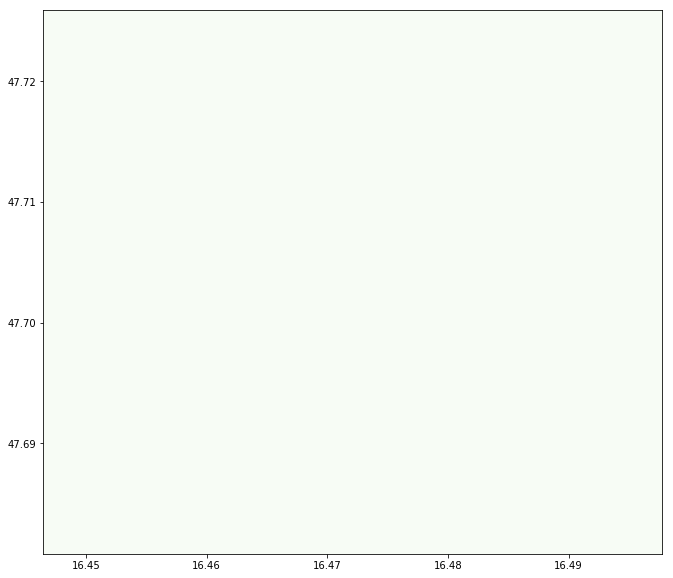

(<ColorInterp.gray: 1>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>, <ColorInterp.undefined: 0>)


In [28]:
file = io.BytesIO(response.content)
tar = tarfile.open(fileobj=file, mode="r")
tar.list()
tar.extractall('../testing/')#('B04.tif', '../testing/')

with rasterio.open(tar.extractfile('B04.tif')) as tif:
    pyplot.figure(figsize=(16,10))
    show((tif,1), transform=tif.transform, cmap='Greens')
    print(tif.colorinterp)

import json
#with open('../testing/userdata.json') as userdata:
    #parsed = json.load(userdata)
    #print(json.dumps(parsed, indent=4, sort_keys=True))
    #print(json.dumps(parsed, indent=2))